In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:

# 定义计算域：2D 空间 (-1,1) x (-1,1)
geom = dde.geometry.Rectangle([-1, -1], [1, 1])

# 设定波数 k
k = 10  # 对应的波长 λ = 2π/k

# ===============================
# 1. 物理约束：Helmholtz 方程
# ===============================
def helmholtz_equation(x, y, f_coeffs):
    """ 计算 Helmholtz 方程残差 """
    laplacian_p = dde.grad.laplacian(y, x)
    return laplacian_p + k**2 * y - f_fourier(x, f_coeffs)

# ===============================
# 2. 设定傅里叶展开的源项
# ===============================
def f_fourier(x, coeffs):
    """ 计算傅里叶展开形式的源项 """
    N = len(coeffs) // 2  # 最高展开阶数
    source_value = np.zeros_like(x[:, 0])
    L = 1  # 归一化长度
    for n in range(-N, N + 1):
        kn = np.pi * n / L
        source_value += coeffs[n + N] * np.exp(1j * kn * x[:, 0]) * np.exp(1j * kn * x[:, 1])
    return np.real(source_value)

# ===============================
# 3. 设定边界条件
# ===============================
def boundary(_, on_boundary):
    return on_boundary

def zero_boundary(_):
    return 0

bc = dde.icbc.DirichletBC(geom, zero_boundary, boundary)

# ===============================
# 4. 设定 DeepONet 结构
# ===============================
degree = 5  # 傅里叶展开的最高阶数
num_eval_points = 20  # 采样点数量
evaluation_points = geom.uniform_points(num_eval_points, boundary=False)  # 采样点
evaluation_points = evaluation_points[:num_eval_points, 0]

# 设定傅里叶系数的采样空间
# 2. 设定傅里叶展开的 PowerSeries
degree = 10  # 最高展开阶数
space = dde.data.PowerSeries(N=degree + 1)

# 设定 PDE Operator
pde = dde.data.PDE(geom, helmholtz_equation, bc, num_domain=1000, num_boundary=100)
pde_op = dde.data.PDEOperatorCartesianProd(pde, space, evaluation_points, num_function=100)

# 设定 DeepONet 结构
dim_x = 2  # 空间维度
p = 64  # 隐藏层维度
net = dde.nn.DeepONetCartesianProd(
    [num_eval_points, 64, p],
    [dim_x, 64, p],
    activation="tanh",
    kernel_initializer="Glorot normal",
)

# ===============================
# 5. 训练模型
# ===============================
model = dde.Model(pde_op, net)
dde.optimizers.set_LBFGS_options(maxiter=1000)
model.compile("L-BFGS")
model.train()

# ===============================
# 6. 预测声场
# ===============================
n_samples = 3
features = space.random(n_samples)  # 采样 3 组傅里叶系数
fx = space.eval_batch(features, evaluation_points)

x_test = geom.uniform_points(1000, boundary=False)
y_pred = model.predict((fx, x_test))

# ===============================
# 7. 可视化结果
# ===============================
fig, axs = plt.subplots(1, n_samples, figsize=(15, 5))
for i in range(n_samples):
    sc = axs[i].scatter(x_test[:, 0], x_test[:, 1], c=y_pred[i].real, cmap="jet", marker=".")
    axs[i].set_title(f"Sample {i+1}")
    plt.colorbar(sc, ax=axs[i])
plt.show()


Compiling model...
'compile' took 0.001058 s

Training model...

0         [2.00e-01, 1.05e+00, 2.39e-02, 3.69e-02]    [2.37e-01, 1.10e+00, 1.88e-02, 4.32e-02]    []  
100       [2.04e-04, 5.25e-04, 6.07e-03, 1.83e-02]    [2.22e-04, 5.16e-04, 2.61e-03, 1.82e-02]    []  
200       [5.27e-05, 3.82e-04, 6.75e-03, 1.53e-02]    [1.07e-04, 2.94e-04, 2.17e-03, 1.48e-02]    []  
300       [1.09e-04, 1.41e-04, 7.16e-03, 1.21e-02]    [8.37e-05, 1.55e-04, 2.24e-03, 1.29e-02]    []  
400       [7.19e-05, 1.52e-04, 7.71e-03, 1.22e-02]    [6.32e-05, 1.40e-04, 2.24e-03, 1.23e-02]    []  
500       [6.21e-05, 2.30e-04, 7.29e-03, 9.45e-03]    [6.53e-05, 2.08e-04, 2.24e-03, 9.91e-03]    []  

Best model at step 500:
  train loss: 1.70e-02
  test loss: 1.24e-02
  test metric: []

'train' took 2912.086637 s



FileNotFoundError: [Errno 2] No such file or directory: '../dataset/stokes.npz'

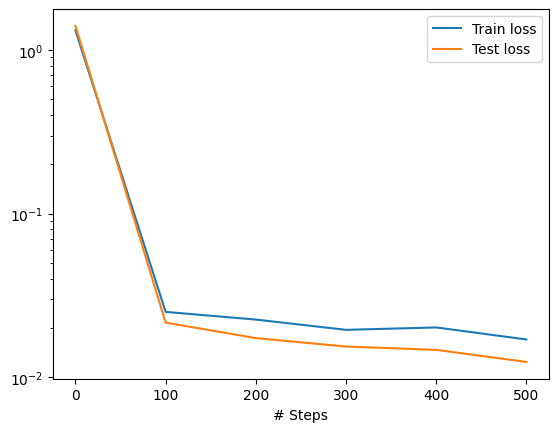

In [2]:
"""Backend supported: tensorflow, pytorch"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np


# PDE equation
def pde(xy, uvp, aux):
    mu = 0.01
    # first order
    du_x = dde.grad.jacobian(uvp, xy, i=0, j=0)
    dv_y = dde.grad.jacobian(uvp, xy, i=1, j=1)
    dp_x = dde.grad.jacobian(uvp, xy, i=2, j=0)
    dp_y = dde.grad.jacobian(uvp, xy, i=2, j=1)
    # second order
    du_xx = dde.grad.hessian(uvp, xy, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(uvp, xy, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(uvp, xy, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(uvp, xy, component=1, i=1, j=1)
    motion_x = mu * (du_xx + du_yy) - dp_x
    motion_y = mu * (dv_xx + dv_yy) - dp_y
    mass = du_x + dv_y
    return motion_x, motion_y, mass

# Geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Boundary condition
# other boundary conditions will be enforced by output transform
def bc_slip_top_func(x, aux_var):
    # using (perturbation / 10 + 1) * x * (1 - x)
    return (aux_var / 10 + 1.) * dde.backend.as_tensor(x[:, 0:1] * (1 - x[:, 0:1]))

bc_slip_top = dde.icbc.DirichletBC(
    geom=geom,
    func=bc_slip_top_func,
    on_boundary=lambda x, on_boundary: np.isclose(x[1], 1.),
    component=0)

# PDE object
pde = dde.data.PDE(
    geom,
    pde,
    bcs=[bc_slip_top],
    num_domain=2000,
    num_boundary=1000,  # sampling a bit more points on boundary (1000 on top bc)
    num_test=500,
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
n_pts_edge = 101  # using the size of true solution, but this is unnecessary
eval_pts = np.linspace(0, 1, num=n_pts_edge)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, num_function=1000,
    function_variables=[0], num_test=100, batch_size=20
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [n_pts_edge, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
    num_outputs=3,
    multi_output_strategy="independent"
)

# Output transform for zero boundary conditions
def out_transform(inputs, outputs):
    x, y = inputs[1][:, 0], inputs[1][:, 1]
    # horizontal velocity on left, right, bottom
    u = outputs[:, :, 0] * (x * (1 - x) * y)[None, :]
    # vertical velocity on all edges
    v = outputs[:, :, 1] * (x * (1 - x) * y * (1 - y))[None, :]
    # pressure on bottom
    p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v, p), axis=2)

net.apply_output_transform(out_transform)

# Model
model = dde.Model(data, net)
model.compile("adam", lr=0.001, decay=("inverse time", 10000, 0.5))
losshistory, train_state = model.train(iterations=500, display_every=100)
dde.utils.plot_loss_history(losshistory)
# save model if needed


In [6]:

model.save('stokes_weights')


'stokes_weights-500.pt'

: 

In [7]:

# Model
model = dde.Model(data = [], net = [])

In [12]:

# load the saved model
model.restore("stokes_weights-500.pt")

# Evaluation
func_feats = func_space.random(1)
v = func_space.eval_batch(func_feats, eval_pts)
v[:] = 0.  # true solution uses zero perturbation
xv, yv = np.meshgrid(eval_pts[:, 0], eval_pts[:, 0], indexing='ij')
xy = np.vstack((np.ravel(xv), np.ravel(yv))).T
sol_pred = model.predict((v, xy))[0]

# sol_true = np.load('../dataset/stokes.npz')['arr_0']
# print('Error on horizontal velocity:', dde.metrics.l2_relative_error(sol_true[:, 0], sol_pred[:, 0]))
# print('Error on vertical velocity:', dde.metrics.l2_relative_error(sol_true[:, 1], sol_pred[:, 1]))
# print('Error on pressure:', dde.metrics.l2_relative_error(sol_true[:, 2], sol_pred[:, 2]))

# Plot
def plot_sol(sol, ax, pressure_lim=0.03, vec_space=4, vec_scale=.5, label=""):
    ax.imshow(sol[:, :, 2].T, origin="lower",
              vmin=-pressure_lim, vmax=pressure_lim, cmap="turbo", alpha=.6)
    ax.quiver(xv[::vec_space, ::vec_space] * 100,
              yv[::vec_space, ::vec_space] * 100,
              sol[::vec_space, ::vec_space, 0],
              sol[::vec_space, ::vec_space, 1], color="k", scale=vec_scale)
    ax.axis('off')
    ax.set_title(label)

fig, ax = plt.subplots(1, 2, dpi=200)
# plot_sol(sol_true.reshape(101, 101, 3), ax[0], label="True")
plot_sol(sol_pred.reshape(101, 101, 3), ax[1], label="Predicted")
# save plot if needed
# plt.savefig('stokes_plot.png')
plt.show()

AttributeError: 'list' object has no attribute 'load_state_dict'

In [3]:
import torch

torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()